## Rx Gate

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler

# Load IBM noise model (replace with a different device if needed)
# backend = FakeBrisbane()  # Simulated IBMQ device
# noise_model = backend.properties()  # Extract noise properties

# Function to create a circuit with an Rx gate (decomposed as √X - Rz - √X)
def create_rx_circuit(beta):
    qc = QuantumCircuit(1)
    qc.sx(0)  # √X gate
    qc.rz(2 * beta, 0)  # Rz(2β) virtual gate (error-free)
    qc.sx(0)  # √X gate
    qc.measure_all()
    return qc

# Define rotation angles to test
beta_values = np.pi*np.linspace(0, 1, 50)  # Test 50 angles between 0 and π

service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")
# Run simulations for each β
simulator = AerSimulator.from_backend(service.backend("ibm_brisbane"))  # Noisy simulator
ideal_simulator = AerSimulator()  # Ideal (noiseless) simulator
pm_noisy = generate_preset_pass_manager(optimization_level=1, backend=simulator)
pm_ideal = generate_preset_pass_manager(optimization_level=1, backend=ideal_simulator)

error_rates_repeated = []
for repeats in range(5):
    error_rates = []
    for beta in beta_values:
        qc = create_rx_circuit(beta)
        shots = 1024*2**6
        # noise
        isa_qc = pm_noisy.run(qc)
        sampler = Sampler(mode=simulator)
        result_noise = sampler.run([isa_qc], shots=shots).result()
        
        # ideal
        isa_qc = pm_ideal.run(qc)
        sampler = Sampler(mode=ideal_simulator)
        result_ideal = sampler.run([isa_qc], shots=shots).result()
        
    
        p_noisy = result_noise[0].data.meas.get_counts().get("1", 0) / shots
        p_ideal = result_ideal[0].data.meas.get_counts().get("1", 0) / shots
        
        # Compute error rate as deviation from ideal probability
        error = abs(p_noisy - p_ideal)
        error_rates.append(error)
    error_rates_repeated.append(error_rates)

err_rate_means = []
err_rate_std = []
for repeat in range(5):
    err_rate_means.append(np.mean(error_rates_repeated[repeat]))
    err_rate_std.append(np.std(error_rates_repeated[repeat]))

In [1]:
err_rate_means = []
err_rate_std = []
for i_beta in range(len(beta_values)):
    err_values = [error_rates_repeated[i][i_beta] for i in range(len(error_rates_repeated))]
    err_rate_means.append(np.mean(err_values))
    err_rate_std.append(np.std(err_values))


NameError: name 'beta_values' is not defined

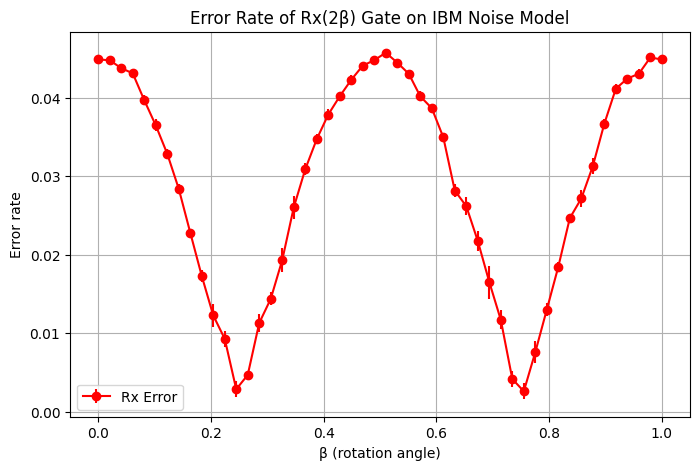

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plot results
plt.figure(figsize=(8, 5))
plt.errorbar(beta_values/np.pi, err_rate_means, yerr=np.array(err_rate_std)/2,
             marker="o", linestyle="-", color="r", label="Rx Error")
plt.xlabel("β (rotation angle)")
plt.ylabel("Error rate")
plt.title("Error Rate of Rx(2β) Gate on IBM Noise Model")
plt.legend()
plt.grid()
plt.show()
plt.savefig("loads_of_points_rx_error.png", bbox_inches="tight")

Almost all the error comes from the CNOT gates. Lets investigate whether this varies with beta

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import numpy as np
import matplotlib.pyplot as plt
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.circuit import Parameter

# details to allow it to run later
service = QiskitRuntimeService(channel="ibm_quantum",
                               token="0156ceeea246c36a6d8709ede062eb539a013399bee42bfcf3c06794a37ae931b088295b383df9d16c3fadc5075ed80dfb5bb8c74af06524a5adfd7762705795")

# Make the circuit
# Can initialise it all now and pass in a parameter 
def make_circuit(gamma):
    qc = QuantumCircuit(2)
    # gamma = Parameter("angle")
    # some hadamard gates first to ensure entanglement
    qc.h(0)
    qc.h(1)
    qc.rzz(2 * gamma, 0, 1)  # Virtual Rz(2γ)
    qc.measure_all()
    return qc

    qc= make_circuit(gamma=np.pi)
    qc.draw("mpl")